<a href="https://colab.research.google.com/github/lizaoh/cognitive_graphs/blob/main/eeg_behavioral_graphs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Top of script

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
import numpy as np
import pandas as pd
import glob
import csv
import math
import matplotlib.pyplot as plt
import matplotlib as mpl
import statistics
import networkx as nx
import scipy.stats as stats
from statsmodels.stats.anova import AnovaRM

plt.rcParams.update({'font.size': 18})

# Load data

In [4]:
logs_path = '/content/gdrive/MyDrive/Colab Notebooks/YoshimiLab/cognitive_graphs/data/behavioral_eeg_catapult/logs/'

df = pd.DataFrame(columns=[
                           'name',
                           'age',
                           'experience',
                           'input_device',
                           'trial_number',
                           'block_number',
                           'puck_x_coord',
                           'puck_y_coord',
                           'trial_score',
                           'current_total_score',
                           'block_best_score',
                           'overall_best_score',
                           'trial_start_time',
                           'puck_click_time',
                           'puck_release_time',
                           'block_sequence'
                           ])

for file in glob.glob(logs_path + "*.log"):
    # print(file)
    file_name = file[len(logs_path):-4]
    # print(file_name)

    with open(file, newline='\n') as logfile:
      log = list(csv.reader(logfile))
      # print(log[-10:])
      # mat = np.array(log[6:]).astype(float) # For easier slicing
      # print(f'name: {file_name}, trialNums: {mat[:,0]}')
      # print(mat)
      # print(log[6:][2])
      game_data = log[6:]

      for i, trial_data in enumerate(game_data):
            # print(game_data[i])
            row = {
                  'name': int(file_name.split('j')[1]),
                  'age': int(log[5][0]),
                  'experience': log[5][1],
                  'input_device': log[5][2],
                  'trial_number': int(game_data[i][0]),
                  'block_number': int(game_data[i][1]),
                  'puck_x_coord': int(game_data[i][2]),
                  'puck_y_coord': int(game_data[i][3]),
                  'trial_score': int(game_data[i][4]),
                  'current_total_score': int(game_data[i][5]),
                  'block_best_score': int(game_data[i][6]),
                  'overall_best_score': int(game_data[i][7]),
                  'trial_start_time': game_data[i][8],
                  'puck_click_time': game_data[i][9],
                  'puck_release_time': game_data[i][10],
                  'block_sequence': [game_data[i][-4:]],
                  'level': [game_data[i][-4 + int(game_data[i][1]) - 1][:-5]]
                }

            row_df = pd.DataFrame(row, columns=row.keys(), index=[0])
            df = pd.concat([df, row_df], ignore_index=True)

In [5]:
# Remove participant 5; has y-coordinates that are outside of the game screen (>600, close to 1000)
eeg_catapult_df = df.loc[df['name'] != 5]
eeg_catapult_df['puck_y_coord'] = eeg_catapult_df['puck_y_coord'].apply(lambda y: 600 - y)

/tmp/ipython-input-3628039189.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eeg_catapult_df['puck_y_coord'] = eeg_catapult_df['puck_y_coord'].apply(lambda y: 600 - y)


In [6]:
eeg_catapult_df.head()

,name,age,experience,input_device,trial_number,block_number,puck_x_coord,puck_y_coord,trial_score,current_total_score,block_best_score,overall_best_score,trial_start_time,puck_click_time,puck_release_time,block_sequence,level
0,13,21,5,0,1,1,111,74,72,72,72,72,24457.400000095367,26920.300000190735,30728.400000095367,"[portalLevel, normalLevel, windLevel, gapLevel]",portal
1,13,21,5,0,2,1,131,98,0,72,72,72,39258.59999990463,40793,43053.300000190735,"[portalLevel, normalLevel, windLevel, gapLevel]",portal
2,13,21,5,0,3,1,110,79,43,115,72,72,45554.300000190735,46297.59999990463,47881.800000190735,"[portalLevel, normalLevel, windLevel, gapLevel]",portal
3,13,21,5,0,4,1,120,77,99,214,99,99,50266.5,52349.5,54055.90000009537,"[portalLevel, normalLevel, windLevel, gapLevel]",portal
4,13,21,5,0,5,1,127,99,0,214,99,99,56438.90000009537,57111.90000009537,58855.90000009537,"[portalLevel, normalLevel, windLevel, gapLevel]",portal


# Functions

In [7]:
def eeg_catapult_get_grid_ids(subjects=None, df=None, grid_res=None, x_range=[0, 800], y_range=[0, 600]):
  all_rows = []

  # Categorize each coordinate into the grid square it belongs to
  for name in subjects:
      subj_df = df.loc[df['name'] == name]

      for b in range(1, 4+1):
        b_df = subj_df.loc[subj_df['block_number'] == b]
        xcoords = np.array(b_df['puck_x_coord'])
        ycoords = np.array(b_df['puck_y_coord'])

        _, x_edges, y_edges = np.histogram2d(xcoords, ycoords, bins=grid_res,
                                            range=[x_range, y_range])

        # Number of edges is one larger than grid size
        # GPT suggests not including rightmost edge because number of bins will be equal to grid size + 1
        x_edges = x_edges[:-1]
        y_edges = y_edges[:-1]

        # Assign each coordinate to grid cell
        x_ids = np.digitize(xcoords, x_edges, right=False) - 1
        y_ids = np.digitize(ycoords, y_edges, right=False) - 1

        # Clamp negative indices to 0
        x_ids[x_ids < 0] = 0
        y_ids[y_ids < 0] = 0

        # Shift x/y for previous values and cast to float so we can assign NaN
        prev_x = np.roll(xcoords, 1).astype(float)
        prev_y = np.roll(ycoords, 1).astype(float)
        prev_x_id = np.roll(x_ids, 1).astype(float)
        prev_y_id = np.roll(y_ids, 1).astype(float)

        # Set first trial's prev_* to None
        prev_x[0] = np.nan
        prev_y[0] = np.nan
        prev_x_id[0] = np.nan
        prev_y_id[0] = np.nan

        n = len(xcoords)
        level = b_df['level'].iloc[0]

        for i in range(n):
          all_rows.append({
              'participant': name,
              'block_num': b,
              'level': level,
              'grid_res': grid_res,
              'trial': i + 1,
              'x': xcoords[i],
              'y': ycoords[i],
              'x_id': x_ids[i],
              'y_id': y_ids[i],
              'prev_x': prev_x[i],
              'prev_y': prev_y[i],
              'prev_x_id': prev_x_id[i],
              'prev_y_id': prev_y_id[i]
          })

  grid_id = pd.DataFrame(all_rows)
  grid_id['id_coord'] = grid_id[['x_id', 'y_id']].apply(tuple, axis=1)

  return grid_id

In [8]:
def eeg_catapult_get_metrics(subjects=None, grid_id_df=None, grid_res=None, trial_window_size=20):
  num_states_data = []

  early_trials_df = grid_id_df.groupby(['participant', 'block_num', 'level']).head(trial_window_size)
  late_trials_df = grid_id_df.groupby(['participant', 'block_num', 'level']).tail(trial_window_size)

  for num in subjects:
    for block in range(1, 4+1):
      early_states = early_trials_df.loc[(early_trials_df['participant'] == num) & (early_trials_df['block_num'] == block), 'id_coord'].values
      late_states = late_trials_df.loc[(late_trials_df['participant'] == num) & (late_trials_df['block_num'] == block), 'id_coord'].values

      num_early_states = set(early_states)
      num_late_states = set(late_states)

      num_states_data.append({
          'participant': num,
          'block_num': block,
          'level': early_trials_df.loc[(early_trials_df['participant'] == num) & (early_trials_df['block_num'] == block), 'level'].iloc[0],
          'early_num_states': len(num_early_states),
          'late_num_states': len(num_late_states),
          'diff_num_states': len(num_early_states) - len(num_late_states),
          'norm_diff_num_states': (len(num_early_states) - len(num_late_states)) / grid_res**2
      })

  num_states_df = pd.DataFrame(num_states_data)

  return num_states_df

In [61]:
def get_hist_mat(subjects=None, level=None, df=None, grid_width=None, trial_window_size=20, x_range=[0, 800], y_range=[0, 600]):
  total_grid_squares = grid_width**2

  # Indexing is adjacency_matrices[subject, early or late, row, columns]
  # Add 1 extra row and column to include the start state (clicking the puck)
  adjacency_matrices = np.zeros((len(subjects), 2, total_grid_squares + 1, total_grid_squares + 1))

  for i, subj in enumerate(subjects):
    xcoords_early = df.loc[(df['name'] == subj) & (df['level'] == level), 'puck_x_coord'][:trial_window_size]
    ycoords_early = df.loc[(df['name'] == subj) & (df['level'] == level), 'puck_y_coord'][:trial_window_size]
    xcoords_late = df.loc[(df['name'] == subj) & (df['level'] == level), 'puck_x_coord'][-trial_window_size:]
    ycoords_late = df.loc[(df['name'] == subj) & (df['level'] == level), 'puck_y_coord'][-trial_window_size:]

    early_hist_mat, _, _ = np.histogram2d(xcoords_early,
                                    ycoords_early,
                                    bins=grid_width,
                                    range=[x_range, y_range])
    late_hist_mat, _, _ = np.histogram2d(xcoords_late,
                                    ycoords_late,
                                    bins=grid_width,
                                    range=[x_range, y_range])

    # Fill first row in each subject's adjacency matrices (for early and late) with the respective probabilities
    # adjacency_matrices[subject, early or late, row, columns]
    adjacency_matrices[i, 0, 0, 1:] = early_hist_mat.flatten()
    adjacency_matrices[i, 1, 0, 1:] = late_hist_mat.flatten()

  # Names each grid square / state as coordinates ((0,0) is bottom left corner)
  states = [(j,i) for i in range((int(np.sqrt(total_grid_squares)))) for j in range((int(np.sqrt(total_grid_squares))))]

  # Coordinate for puck spawn coordinate
  states.insert(0, (grid_width, grid_width))

  return adjacency_matrices, states

In [36]:
def plot_markov_chains(subj_num=[0], level=None, adj_mat=None, grid_res=None, df=None,
                       states=None, hist_plot_df=None, wt_add=0, wt_mult=1, wt_alpha=1, node_size=80,
                       cmap=plt.cm.Greys, label_pos=0.5, vertical_alignment='center', horizontal_alignment='center',
                       label_alpha=1, as_percent=False, initial_trial='first', final_trial='last',
                       figsize=(10,8)):
  avg_state_probs = pd.DataFrame()
  all_mats = []
  if len(subj_num) == 1:
      all_mats = adj_mat[subj_num]
  elif len(subj_num) > 1:
      for subj in subj_num:
          all_mats.append(adj_mat[subj])
  names = df['name'].unique()

  start_state = states[0]

  for s, subj_mats in enumerate(all_mats):
      num_states = []
      avg_prob = []
      for m, mat in enumerate(subj_mats):
          # A set for saving states used in early trials and late trials (sets don't allow for duplicates, so better than a list here)
          all_destination_states = set()
          nonzero_wts = 0
          # For adding the edge labels with the respective probabilities
          edge_labels = {}

          # Save states used in first and last 15 trials
          for prob, state in zip(mat.flatten(), states):
              if prob > 0:
                  all_destination_states.add(state)
                  nonzero_wts += 1

          destination_state_probs = [[prob, state] for prob, state in \
                                  zip(mat.flatten(), states) \
                                  if state in all_destination_states]

          # Creates Markov chain visualizations using NetworkX
          graph = nx.DiGraph()
          start_state = states[0]
          graph.add_nodes_from(states)
          pos = {state: list(state) for state in states}

          for [prob, dest_state] in destination_state_probs:
              edge_labels[(start_state, dest_state)] = label = f'{prob:.02f}'
              graph.add_edge(start_state,
                                    dest_state,
                                    weight=prob,
                                    label=label
                                    )

          # For making the edges more visible (especially when the probability is 0)
          weights = list(nx.get_edge_attributes(graph, 'weight').values())
          # avg_probability = np.sum(weights) / nonzero_wts
          # avg_prob.append(avg_probability)
          num_states.append(nonzero_wts)

          # For making the edges more visible (especially when the probability is 0
          weights_scaled_up = [w1 * 10 + 0.25 for w1 in weights]

          # Colors the nodes for the release states light blue and the start state pink
          node_color_map = ['#eaeaea'] * len(states)
          node_color_map[0] = 'pink'
          path_nodes_cmap = ['#1f77b4'] * len(all_destination_states)

          # Arranges nodes according to state coordinates (more crowded and harder to read)
          # pos = {state:list(state) for state in all_destination_states}
          # pos[(-1, -1)] = [-1, -1]

          edge_colors = [cmap(w, alpha=wt_alpha) for w in weights_scaled_up]

          fig, ax = plt.subplots(figsize=figsize)
          nx.draw_networkx(graph,
                            pos,
                            node_color=node_color_map,
                            node_size=node_size,
                            edge_color=edge_colors,
                            width=[w for w in weights_scaled_up],
                            edge_cmap=cmap,
                            with_labels=False)
          # nx.draw_networkx_edge_labels(graph, pos, edge_labels)
          nx.draw_networkx_nodes(graph,
                                pos,
                                nodelist=all_destination_states,
                                node_size=node_size,
                                node_color=path_nodes_cmap)
          if m == 0:
            trial_type = 'first'
          elif m == 1:
            trial_type = 'last'
          plt.title(f'Participant {names[s]} {level} level skill graph for {trial_type} 20 trials')
          plt.axis('off')
          plt.show()

          # plt.title(f'Participant {names[s]} {level} level skill graph for {trial_type} 20 trials')
          print(f'Number of states visited for {trial_type} 20 trials: {len(weights)}')
          # print(f'Average state probability for {trial_type} 20 trials: {avg_probability}')

# Set grid resolution

In [11]:
# Grid resolution is 5% of the average of the width and height of game
# screen in pixels
grid_res = math.floor(.05 * ((800 + 600) / 2))
print(grid_res)

35


# Number of states visited in first and last quarter of trials

first 20 and last 20 trials

In [12]:
eeg_catapult_subjects = eeg_catapult_df['name'].unique()
grid_id = eeg_catapult_get_grid_ids(eeg_catapult_subjects, eeg_catapult_df, grid_res)

In [13]:
grid_id.head()

,participant,block_num,level,grid_res,trial,x,y,x_id,y_id,prev_x,prev_y,prev_x_id,prev_y_id,id_coord
0,13,1,portal,35,1,111,74,4,4,NaN,NaN,NaN,NaN,"(4, 4)"
1,13,1,portal,35,2,131,98,5,5,111.0,74.0,4.0,4.0,"(5, 5)"
2,13,1,portal,35,3,110,79,4,4,131.0,98.0,5.0,5.0,"(4, 4)"
3,13,1,portal,35,4,120,77,5,4,110.0,79.0,4.0,4.0,"(5, 4)"
4,13,1,portal,35,5,127,99,5,5,120.0,77.0,5.0,4.0,"(5, 5)"


In [14]:
eeg_num_states_df = eeg_catapult_get_metrics(eeg_catapult_subjects, grid_id, grid_res, trial_window_size=20)

In [15]:
eeg_num_states_df.head()

,participant,block_num,level,early_num_states,late_num_states,diff_num_states,norm_diff_num_states
0,13,1,portal,4,2,2,0.001633
1,13,2,normal,6,3,3,0.002449
2,13,3,wind,4,3,1,0.000816
3,13,4,gap,6,5,1,0.000816
4,2,1,normal,12,5,7,0.005714


# T test on difference in number of states visited from first and last 15 trials

In [16]:
for level in eeg_catapult_df['level'].unique():
  level_df = eeg_num_states_df.loc[eeg_num_states_df['level'] == level]
  print(f'{level} level\n', level_df['diff_num_states'].describe())
  print('\n')

portal level
 count    17.000000
mean      3.176471
std       1.776066
min       0.000000
25%       3.000000
50%       3.000000
75%       4.000000
max       6.000000
Name: diff_num_states, dtype: float64


normal level
 count    17.000000
mean      2.764706
std       2.681637
min      -3.000000
25%       1.000000
50%       3.000000
75%       4.000000
max       8.000000
Name: diff_num_states, dtype: float64


wind level
 count    17.000000
mean      2.882353
std       2.342070
min      -2.000000
25%       2.000000
50%       3.000000
75%       4.000000
max       9.000000
Name: diff_num_states, dtype: float64


gap level
 count    17.000000
mean      1.705882
std       1.829095
min      -1.000000
25%       0.000000
50%       2.000000
75%       3.000000
max       6.000000
Name: diff_num_states, dtype: float64




In [17]:
for level in eeg_catapult_df['level'].unique():
  level_df = eeg_num_states_df.loc[eeg_num_states_df['level'] == level]
  print(f'{level} level\n', level_df['early_num_states'].describe())
  print('\n')

portal level
 count    17.000000
mean      6.764706
std       1.855041
min       4.000000
25%       5.000000
50%       7.000000
75%       8.000000
max      10.000000
Name: early_num_states, dtype: float64


normal level
 count    17.000000
mean      6.823529
std       2.404041
min       3.000000
25%       5.000000
50%       7.000000
75%       8.000000
max      12.000000
Name: early_num_states, dtype: float64


wind level
 count    17.000000
mean      8.823529
std       2.743977
min       4.000000
25%       7.000000
50%       9.000000
75%      10.000000
max      15.000000
Name: early_num_states, dtype: float64


gap level
 count    17.000000
mean      6.705882
std       2.172691
min       3.000000
25%       6.000000
50%       6.000000
75%       7.000000
max      13.000000
Name: early_num_states, dtype: float64




In [18]:
for level in eeg_catapult_df['level'].unique():
  level_df = eeg_num_states_df.loc[eeg_num_states_df['level'] == level]
  print(f'{level} level\n', level_df['late_num_states'].describe())
  print('\n')

portal level
 count    17.000000
mean      3.588235
std       1.175735
min       2.000000
25%       3.000000
50%       4.000000
75%       5.000000
max       5.000000
Name: late_num_states, dtype: float64


normal level
 count    17.000000
mean      4.058824
std       1.144038
min       2.000000
25%       4.000000
50%       4.000000
75%       4.000000
max       7.000000
Name: late_num_states, dtype: float64


wind level
 count    17.000000
mean      5.941176
std       2.838807
min       3.000000
25%       4.000000
50%       6.000000
75%       7.000000
max      13.000000
Name: late_num_states, dtype: float64


gap level
 count    17.000000
mean      5.000000
std       2.524876
min       2.000000
25%       4.000000
50%       4.000000
75%       5.000000
max      13.000000
Name: late_num_states, dtype: float64




In [20]:
for level in eeg_catapult_df['level'].unique():
  level_df = eeg_num_states_df.loc[eeg_num_states_df['level'] == level]
  mean_diff = np.mean(level_df['diff_num_states'])
  std_diff = np.std(level_df['diff_num_states'], ddof=1)

  t_stat, p_val = stats.ttest_rel(np.array(level_df['early_num_states']), np.array(level_df['late_num_states']))

  deg_of_freedom = len(level_df['early_num_states']) - 1

  conf_level = 0.95
  alpha = 1 - conf_level
  crit_value = stats.t.ppf(1 - alpha / 2, deg_of_freedom)
  margin_error = crit_value * (std_diff / np.sqrt(len(level_df['diff_num_states'])))
  conf_interval = [mean_diff - margin_error, mean_diff + margin_error]

  cohen_d = mean_diff / std_diff

  print(level)
  print(f"Mean difference: {mean_diff}")
  print(f"Standard error of the mean: {std_diff}")
  print(f"t-statistic: {t_stat}")
  print(f"p-value: {p_val}")
  print(f"95% Confidence Interval: {conf_interval}")
  print(f"Cohen's d: {cohen_d}")
  print('\n')

portal
Mean difference: 3.176470588235294
Standard error of the mean: 1.7760663739584404
t-statistic: 7.374118413588324
p-value: 1.5693862204486271e-06
95% Confidence Interval: [np.float64(2.2633015210812806), np.float64(4.089639655389307)]
Cohen's d: 1.788486418531576


normal
Mean difference: 2.764705882352941
Standard error of the mean: 2.6816369013325114
t-statistic: 4.250826937473665
p-value: 0.00061013753708157
95% Confidence Interval: [np.float64(1.3859354132190607), np.float64(4.143476351486822)]
Cohen's d: 1.0309769682014565


wind
Mean difference: 2.8823529411764706
Standard error of the mean: 2.3420704766609943
t-statistic: 5.074247656169278
p-value: 0.00011270261594471207
95% Confidence Interval: [np.float64(1.6781714174787976), np.float64(4.086534464874143)]
Cohen's d: 1.2306858268781635


gap
Mean difference: 1.7058823529411764
Standard error of the mean: 1.829094922439543
t-statistic: 3.845362555964416
p-value: 0.0014292311197349476
95% Confidence Interval: [np.float64(0

In [22]:
print(AnovaRM(data=eeg_num_states_df, depvar='diff_num_states', subject='participant',
              within=['level'], aggregate_func='mean').fit())

               Anova
      F Value Num DF  Den DF Pr > F
-----------------------------------
level  1.5073 3.0000 48.0000 0.2246



# Cognitive graphs

For just one level

In [33]:
df = eeg_catapult_df
total_grid_squares = grid_res**2

# Indexing is adjacency_matrices[subject, early or late, row, columns]
# Add 1 extra row and column to include the start state (clicking the puck)
adjacency_matrices = np.zeros((len(df['name'].unique()), 2, total_grid_squares + 1, total_grid_squares + 1))

for i, subj_mat in enumerate(max_grid_hists):
  # print(i, subj_mats[2])
  early_hist_mat = subj_mat[0]
  late_hist_mat = subj_mat[1]

  # Fill first row in each subject's adjacency matrices (for early and late) with the respective probabilities
  # adjacency_matrices[subject, early or late, row, columns]
  adjacency_matrices[i, 0, 0, 1:] = early_hist_mat.flatten()
  adjacency_matrices[i, 1, 0, 1:] = late_hist_mat.flatten()

# Names each grid square / state as coordinates ((0,0) is bottom left corner)
states = [(j,i) for i in range((int(np.sqrt(total_grid_squares)))) for j in range((int(np.sqrt(total_grid_squares))))]

# Coordinate for puck spawn coordinate
states.insert(0, (grid_res, grid_res))

## Graphs

In [63]:
subjects = df['name'].unique()
adjacency_matrices, states = get_hist_mat(subjects, level_to_use, eeg_catapult_df,
                                          grid_res, trial_window_size=20)

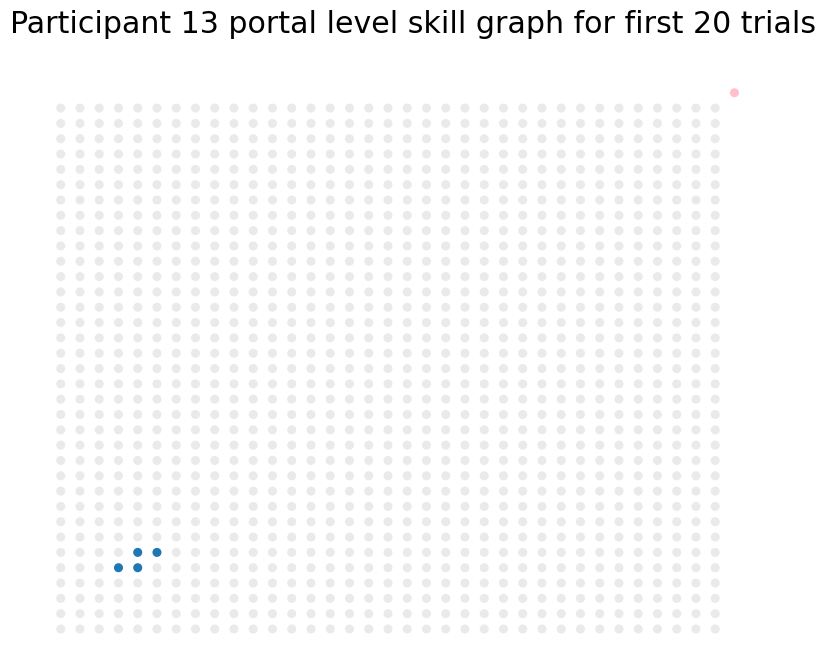

Number of states visited for first 20 trials: 4


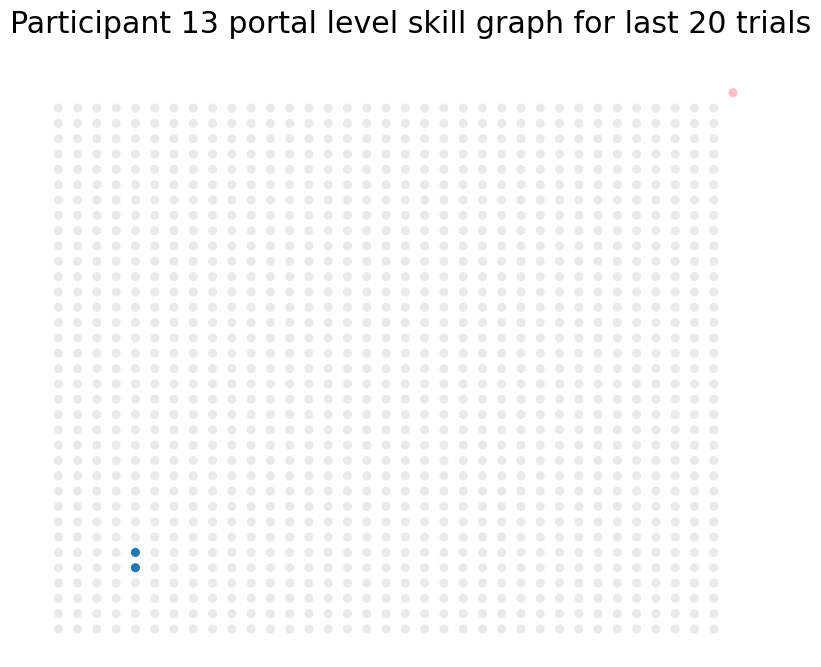

Number of states visited for last 20 trials: 2


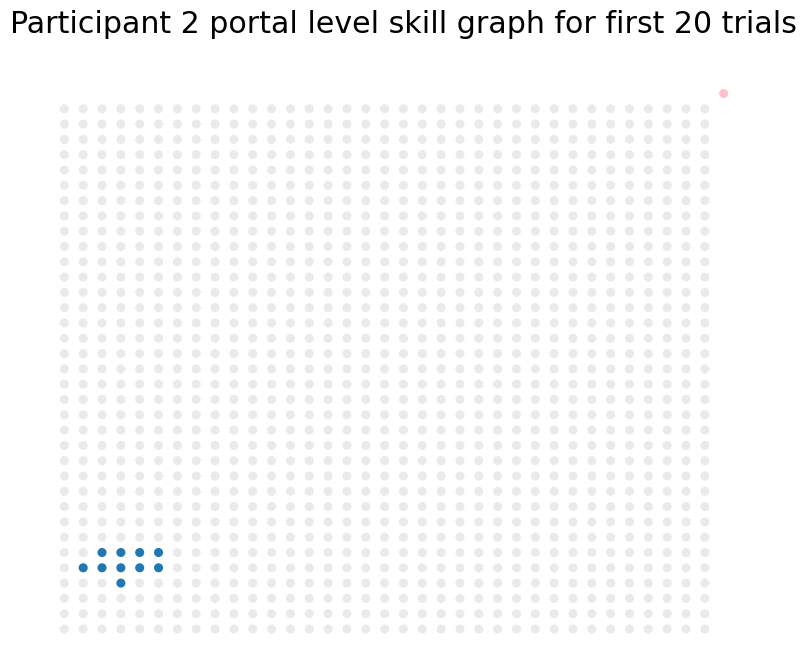

Number of states visited for first 20 trials: 10


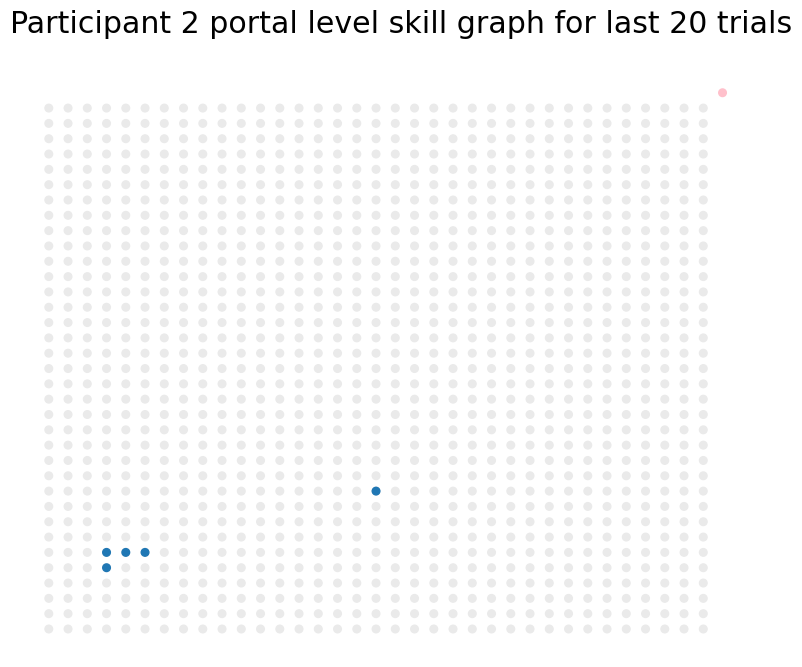

Number of states visited for last 20 trials: 5


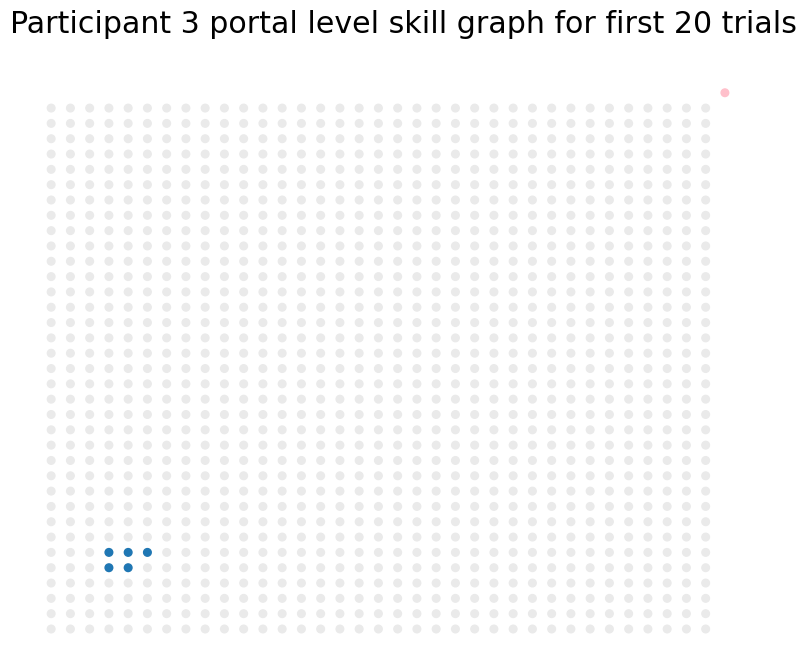

Number of states visited for first 20 trials: 5


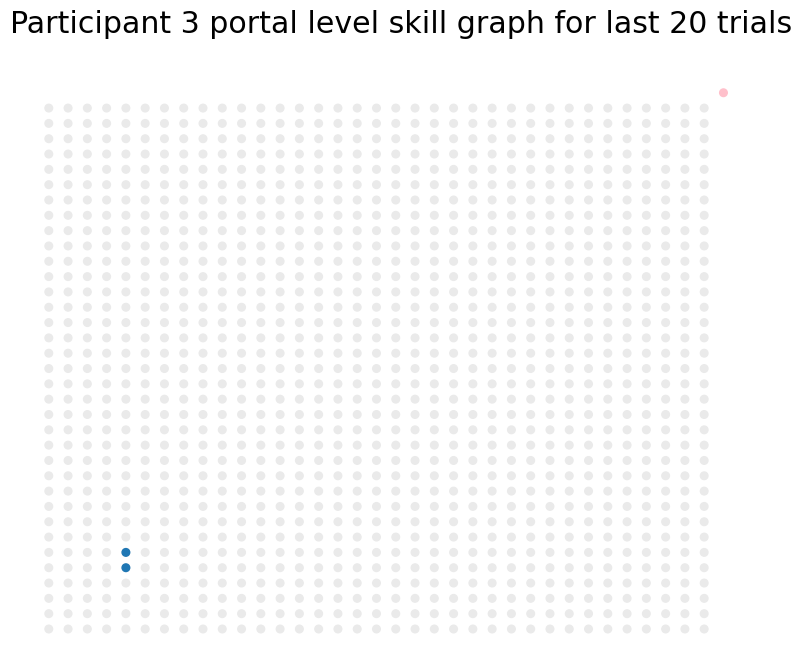

Number of states visited for last 20 trials: 2


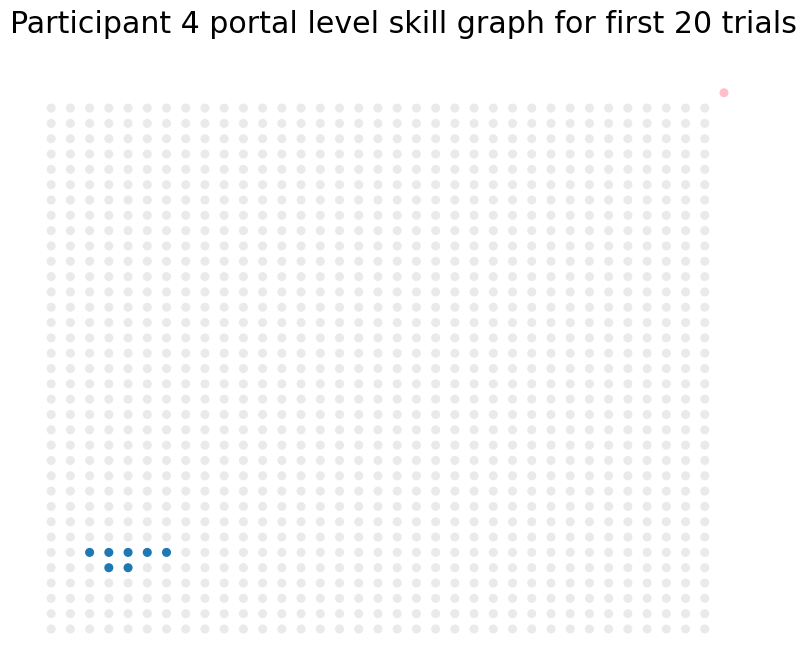

Number of states visited for first 20 trials: 7


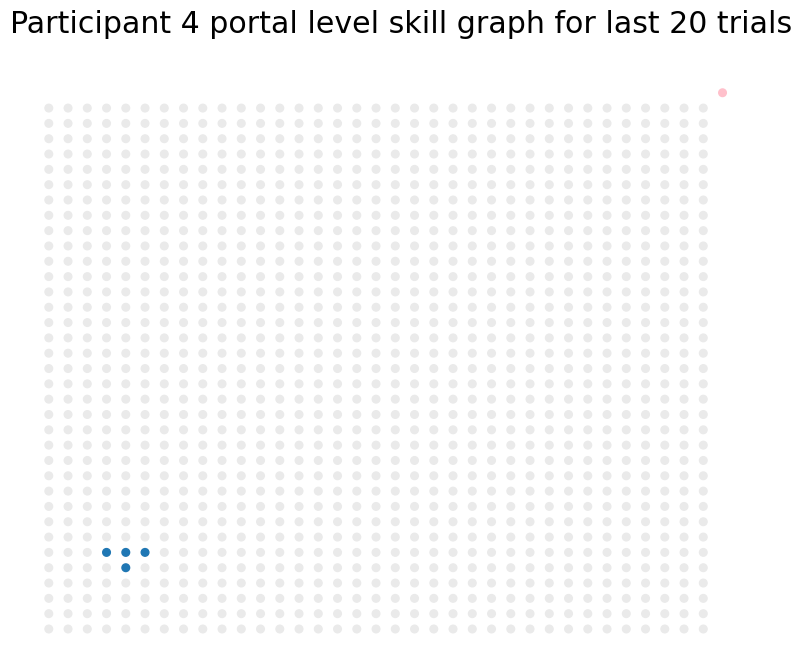

Number of states visited for last 20 trials: 4


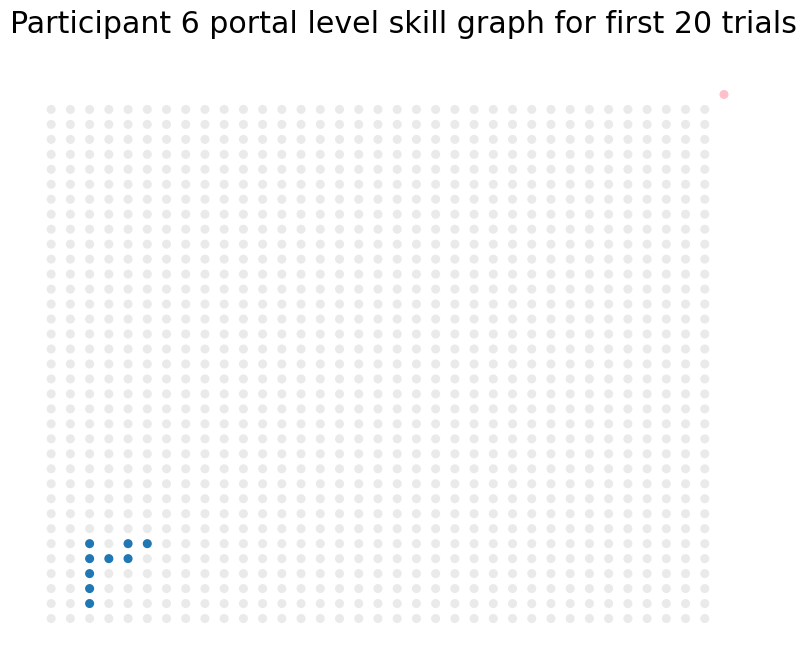

Number of states visited for first 20 trials: 9


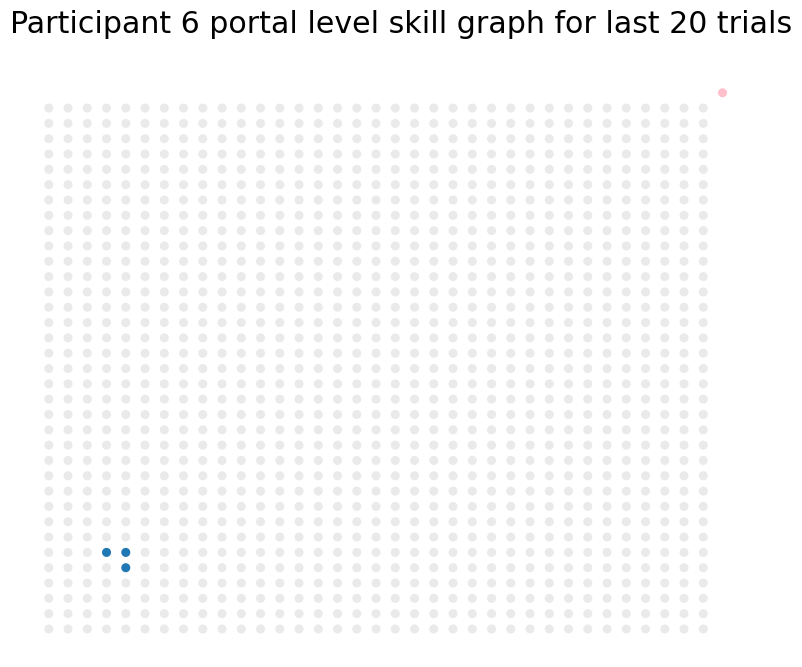

Number of states visited for last 20 trials: 3


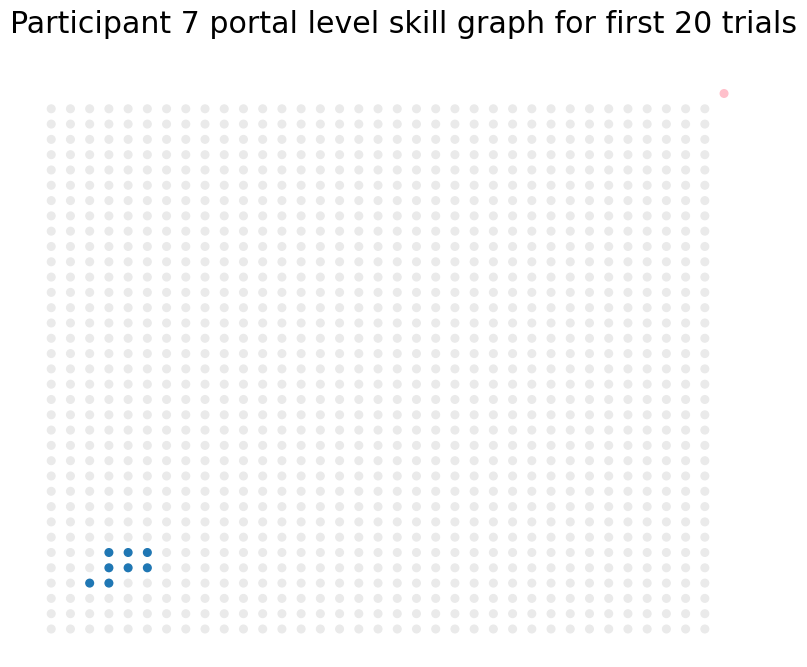

Number of states visited for first 20 trials: 8


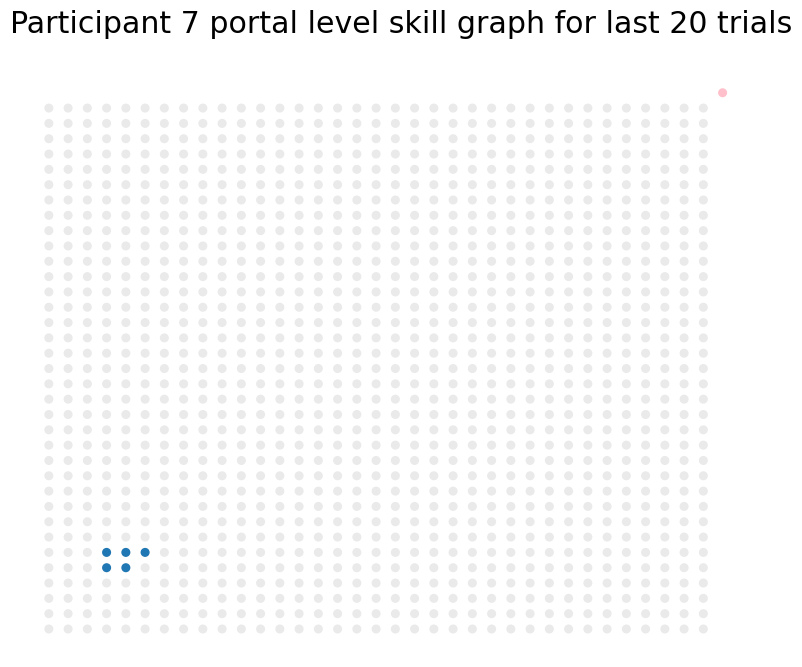

Number of states visited for last 20 trials: 5


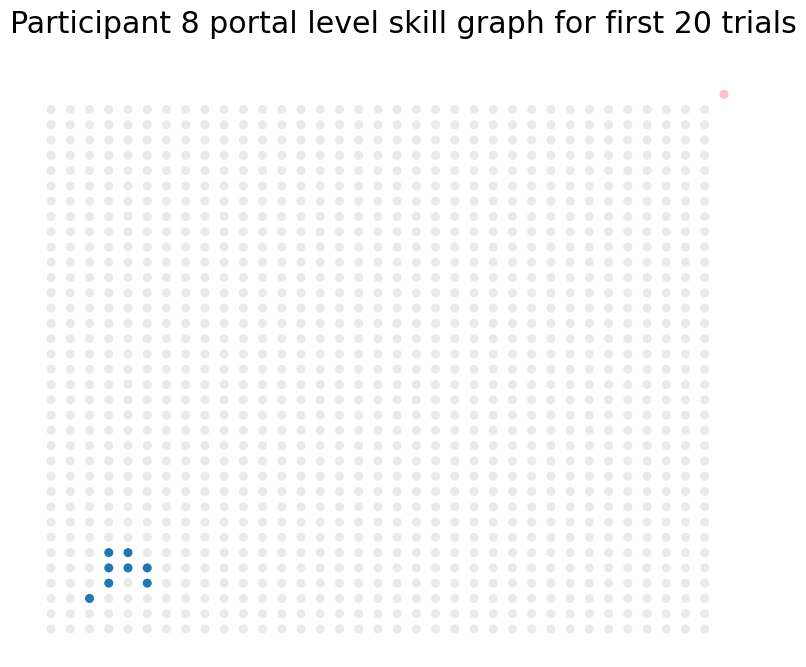

Number of states visited for first 20 trials: 8


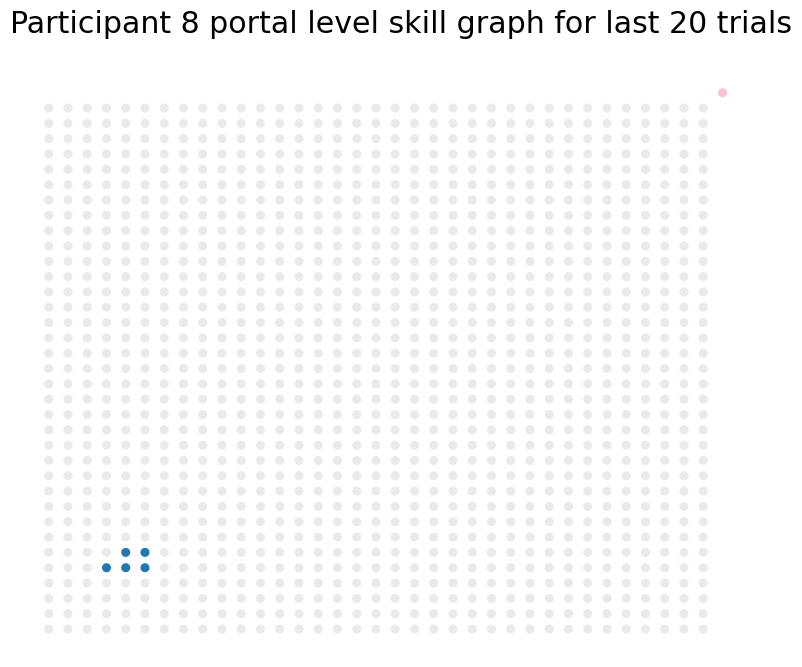

Number of states visited for last 20 trials: 5


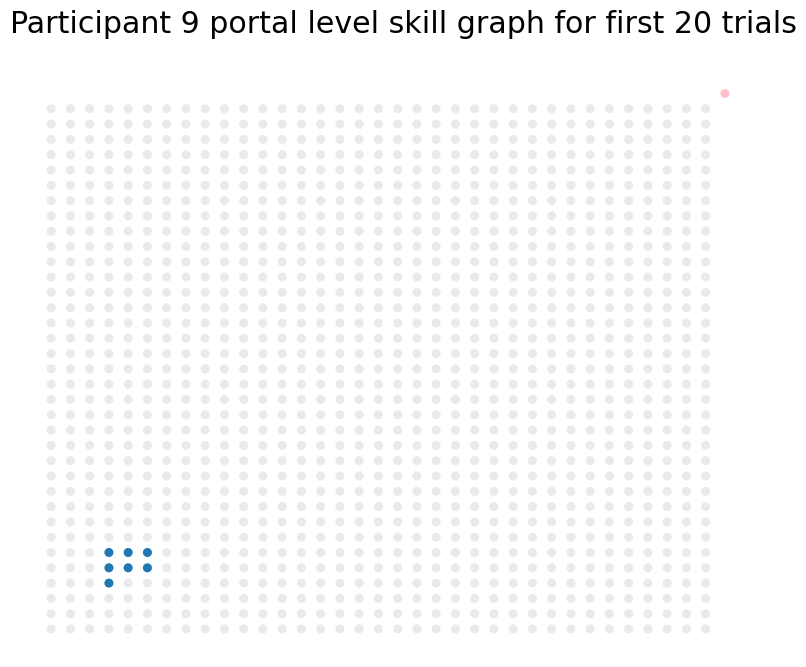

Number of states visited for first 20 trials: 7


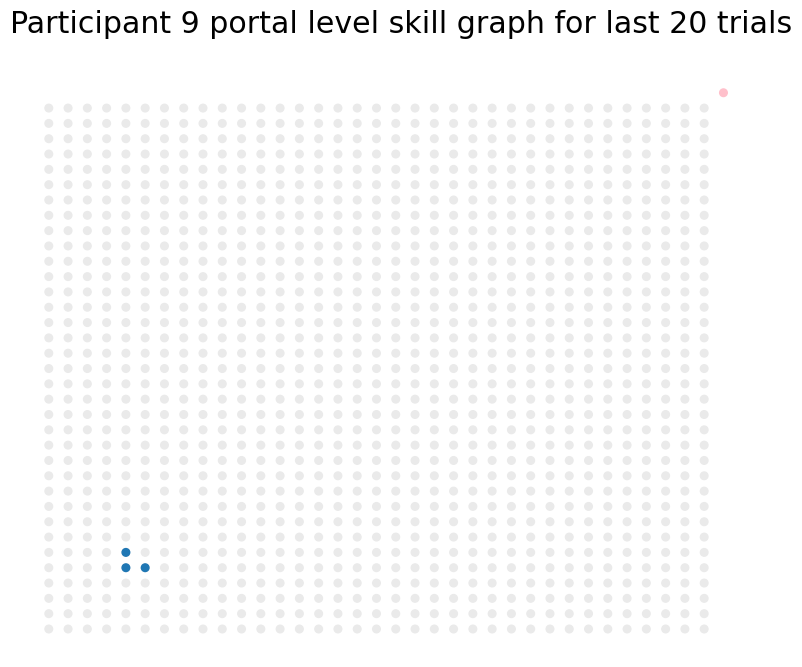

Number of states visited for last 20 trials: 3


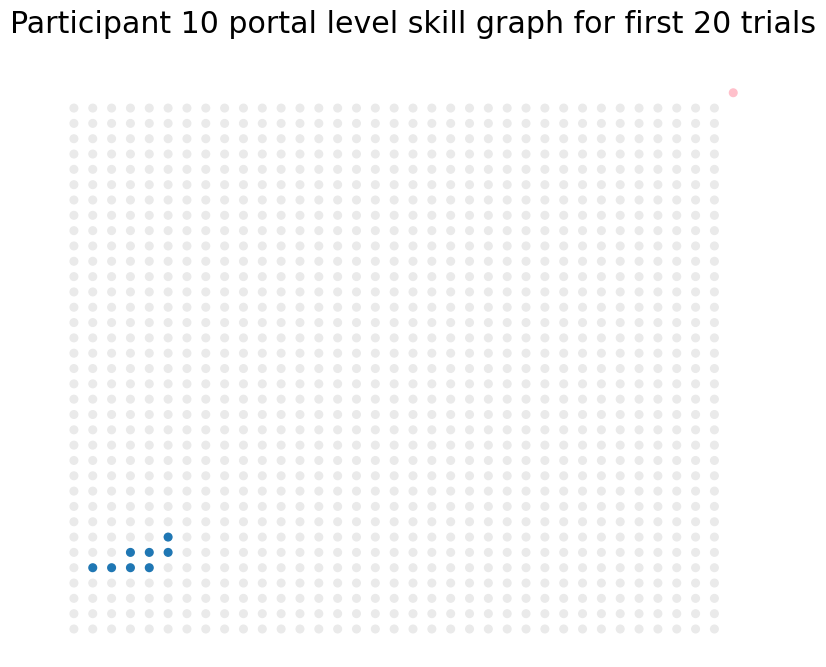

Number of states visited for first 20 trials: 8


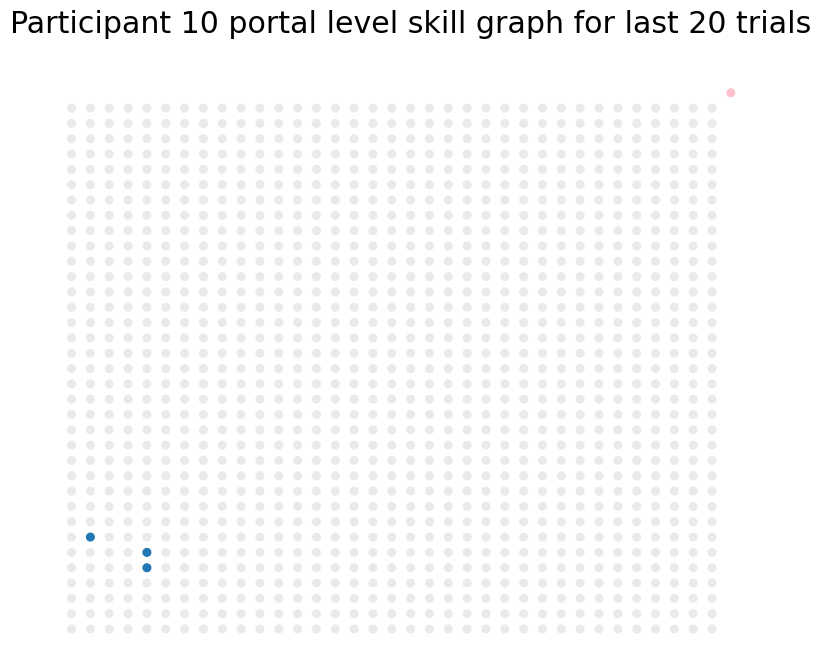

Number of states visited for last 20 trials: 3


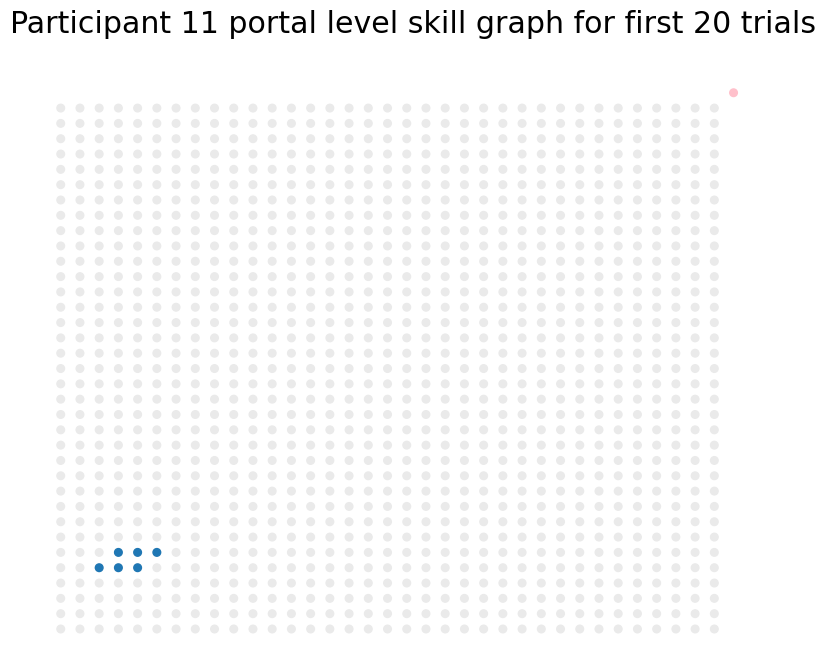

Number of states visited for first 20 trials: 6


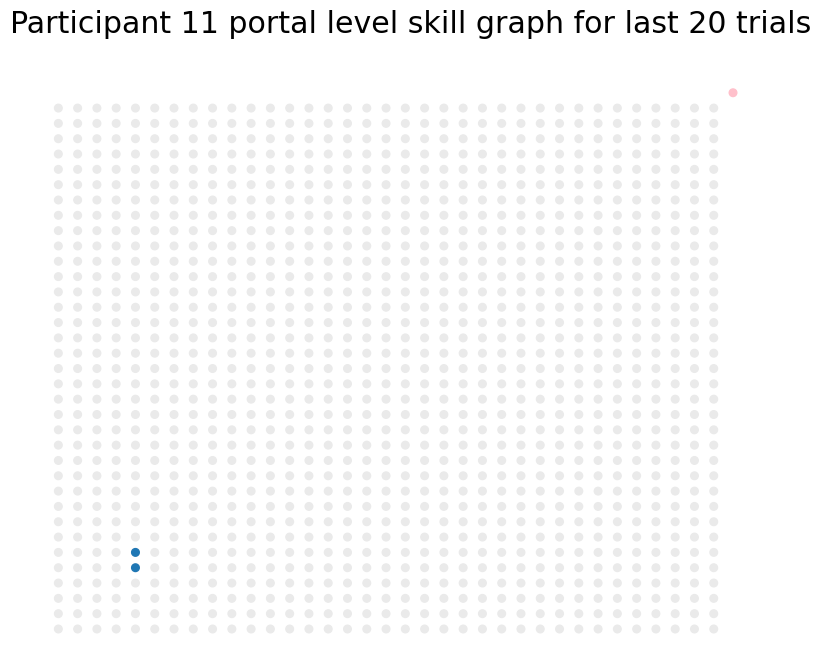

Number of states visited for last 20 trials: 2


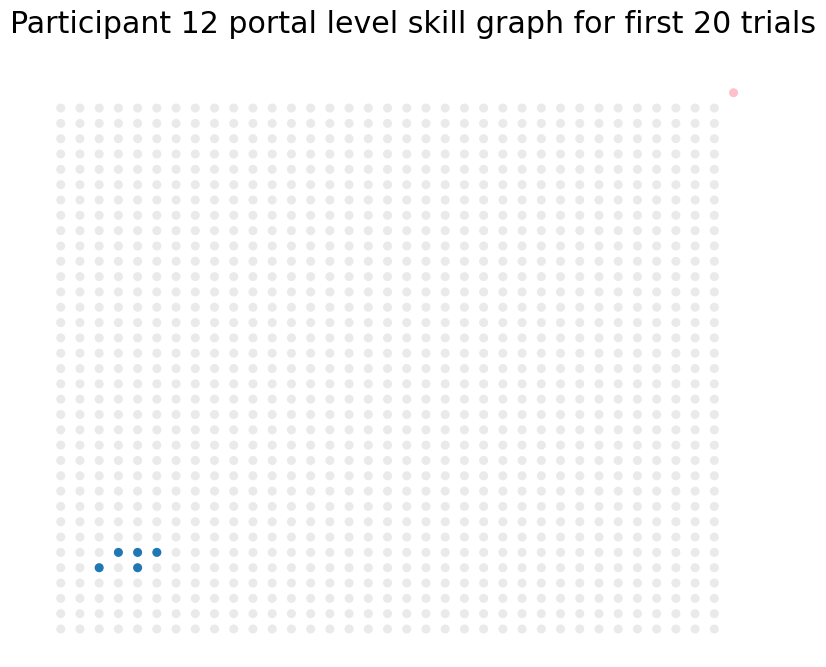

Number of states visited for first 20 trials: 5


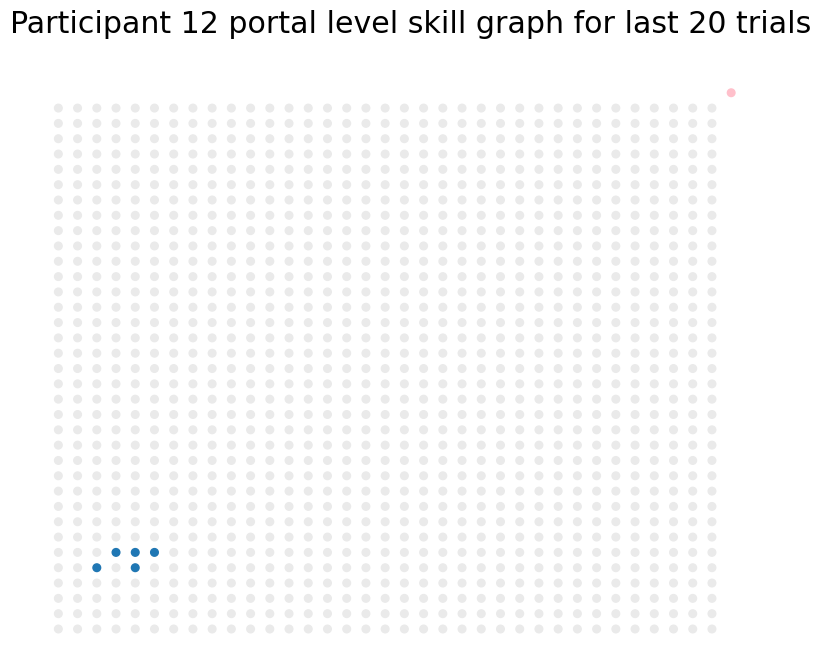

Number of states visited for last 20 trials: 5


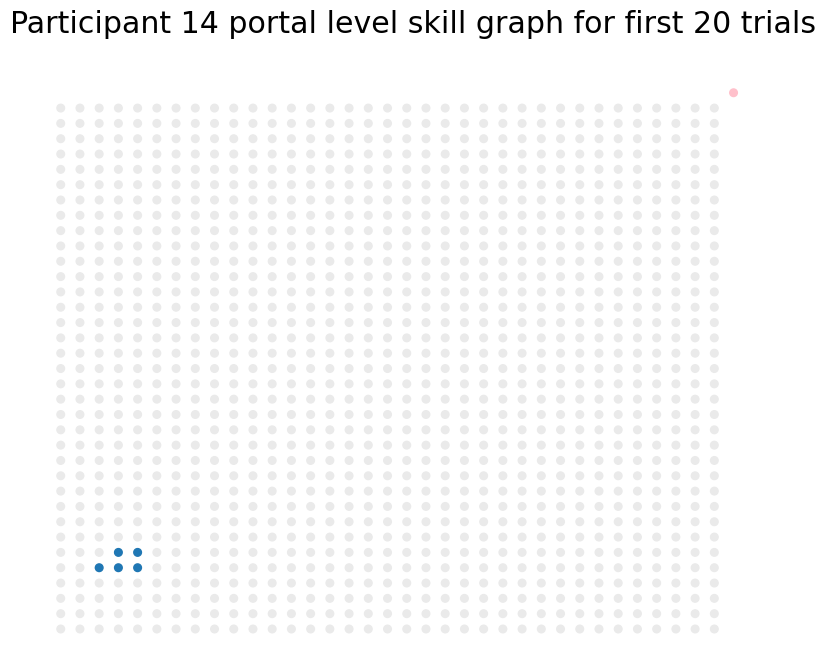

Number of states visited for first 20 trials: 5


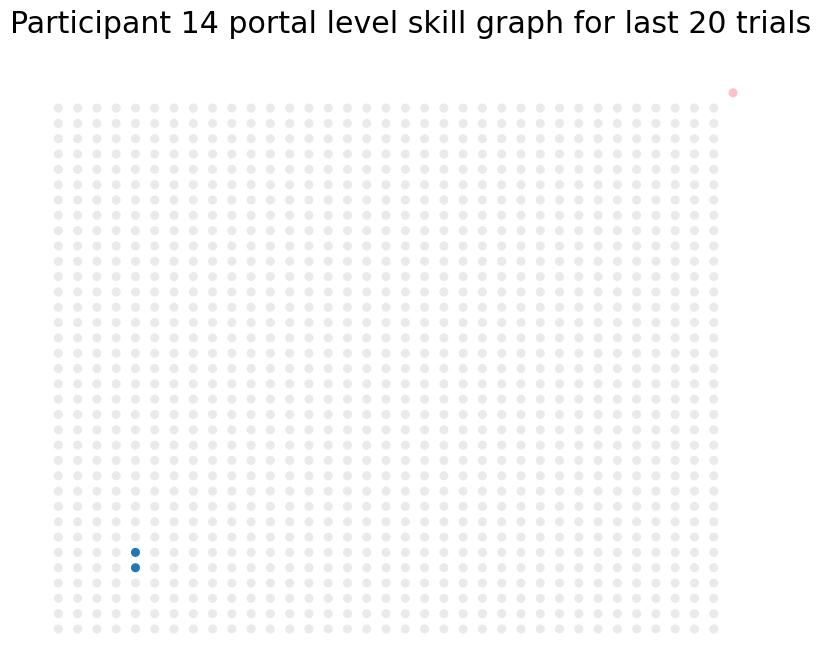

Number of states visited for last 20 trials: 2


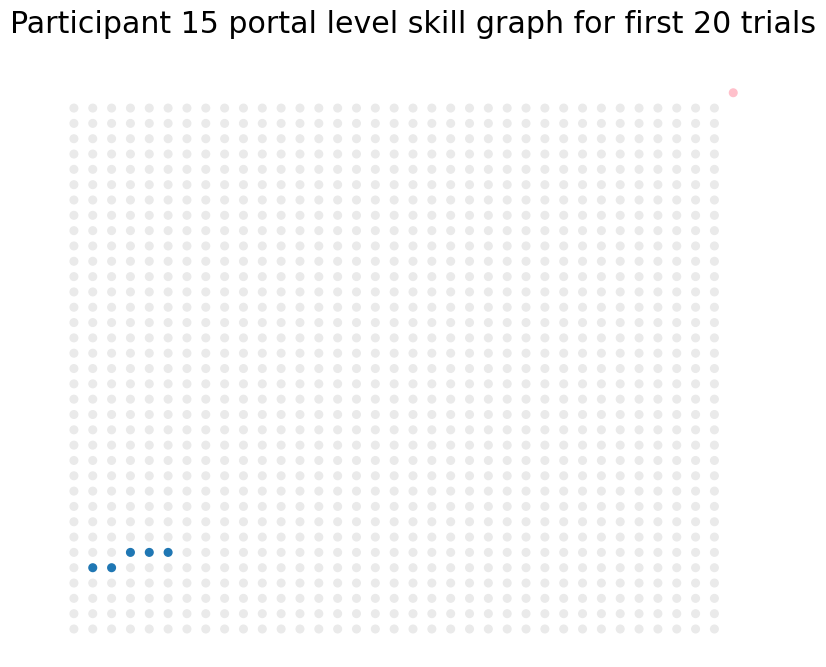

Number of states visited for first 20 trials: 5


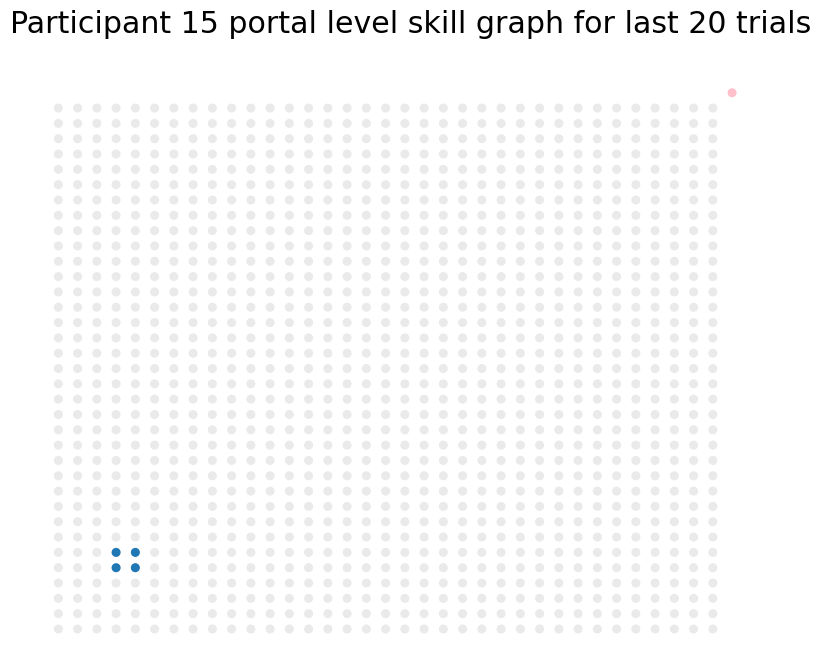

Number of states visited for last 20 trials: 4


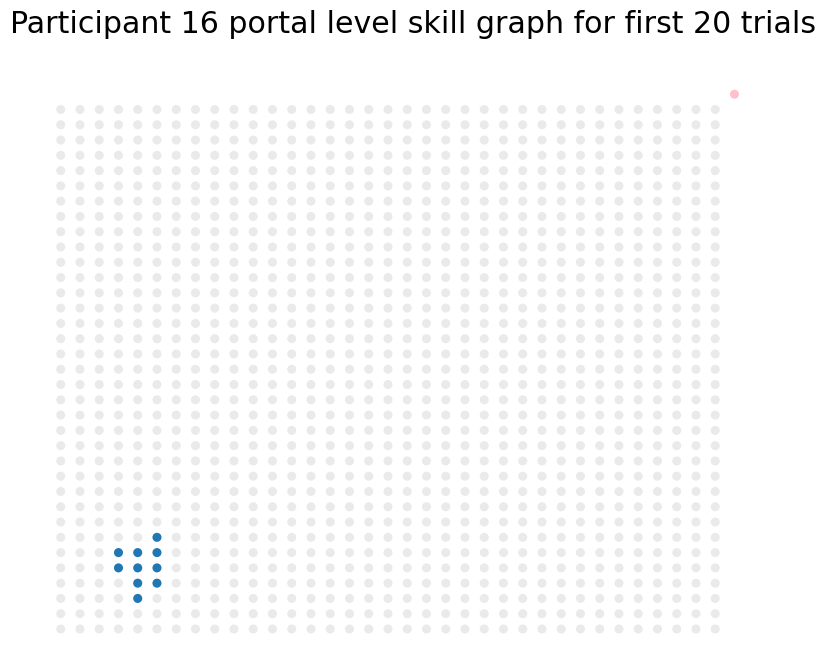

Number of states visited for first 20 trials: 10


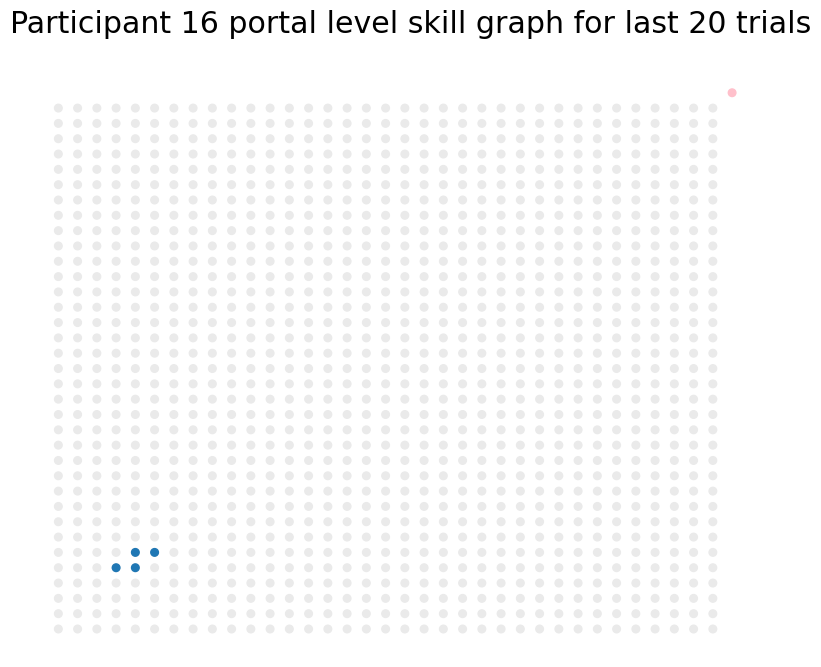

Number of states visited for last 20 trials: 4


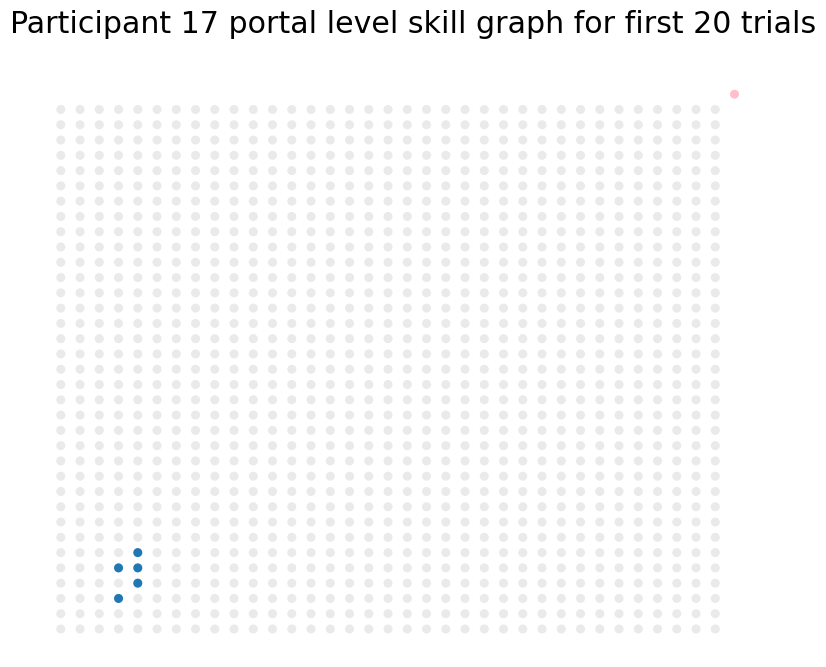

Number of states visited for first 20 trials: 5


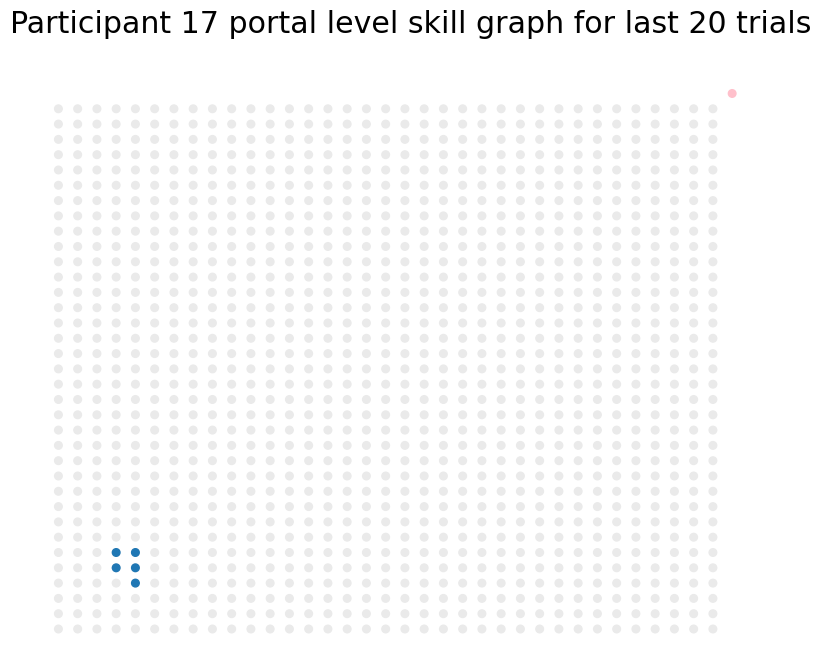

Number of states visited for last 20 trials: 5


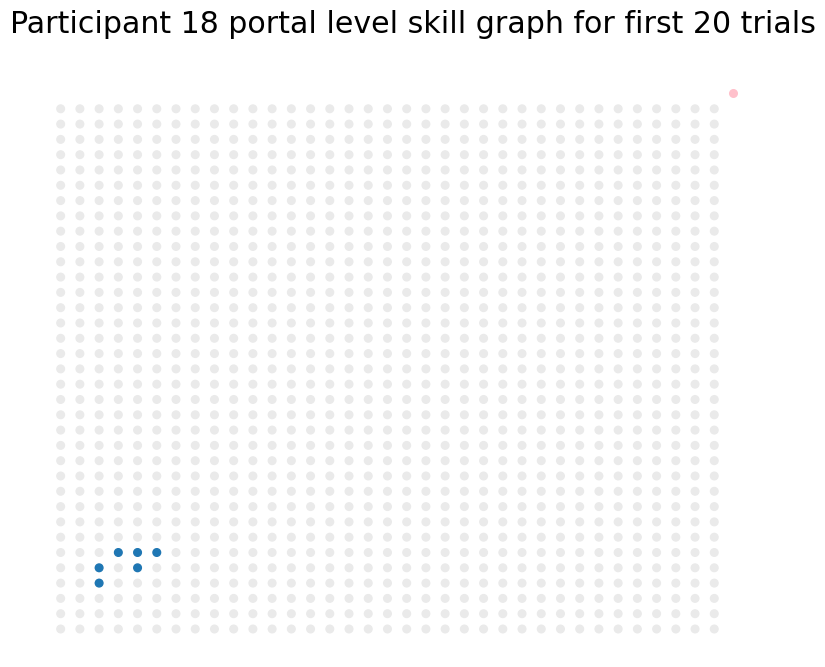

Number of states visited for first 20 trials: 6


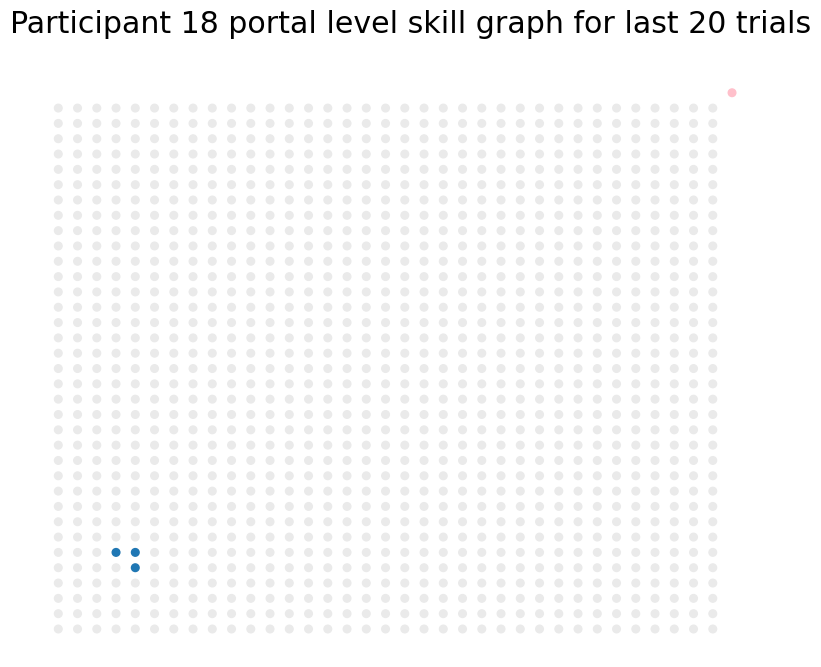

Number of states visited for last 20 trials: 3


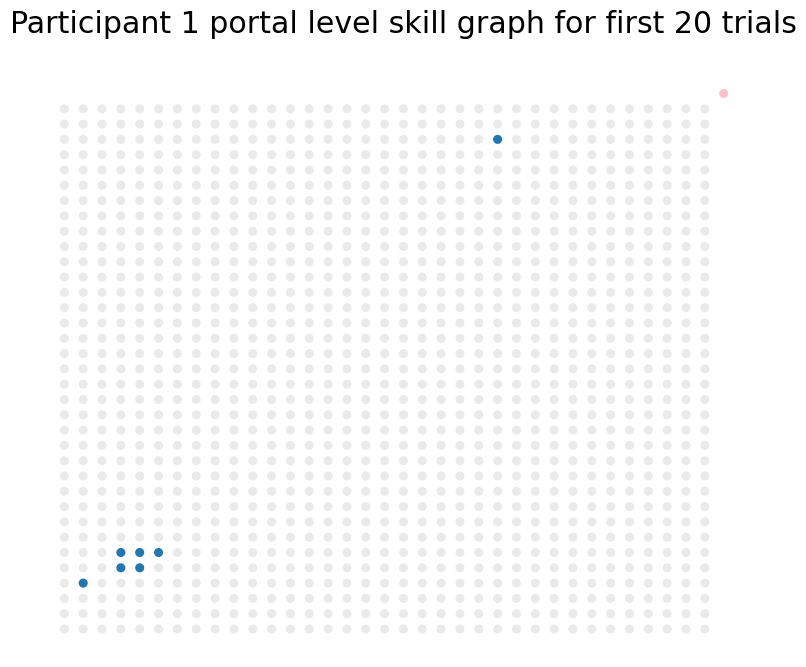

Number of states visited for first 20 trials: 7


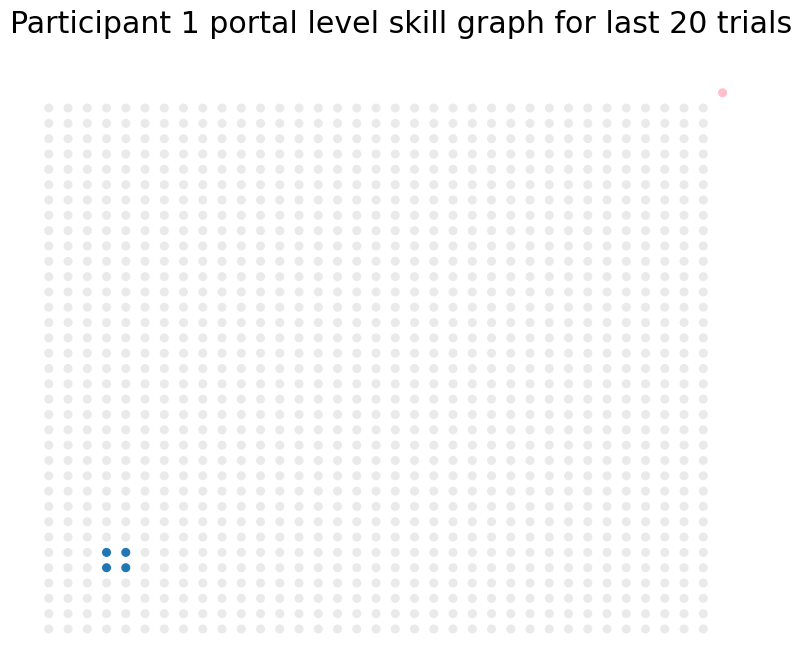

Number of states visited for last 20 trials: 4


In [64]:
avg_state_probs = plot_markov_chains(subj_num=[n for n in range(len(eeg_catapult_df['name'].unique()))],
                                      level=level_to_use, adj_mat=adjacency_matrices,
                                      grid_res=grid_res, df=eeg_catapult_df,
                                      states=states, wt_mult=0, wt_alpha=0, node_size=30)